To take advantage of the temporal aspect of the data, we will split the dataset into 2 separate time periods for training and testing data:
* Training Data: February (2017/02/01 - 2017/02/28)
* Testing Data: March (2017/03/01 - 2017/03/31)

In [2]:
# Load Libraries
import pandas as pd
import time
from datetime import datetime
import numpy as np

## Data Preprocessing <br>

Both the training data and the testing data are biased towards user who did not churn. To balance it out, both need to be downsampled. Previously we had already downsampled the churn data for February. We also have to do it for our churn data for March.

In [3]:
feb_churn = pd.read_csv('./EDA_Data/train_modified.csv')
march_churn = pd.read_csv('./Data2/train_v2.csv')

In [9]:
feb_churn.describe()

,is_churn
count,138471.000000
mean,0.458370
std,0.498266
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
march_churn.describe()

,is_churn
count,970960.000000
mean,0.089942
std,0.286099
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [11]:
np.sum(march_churn.is_churn == 1)

87330

In [4]:
#Split train data into churn and no churn dataframes
train_churn = march_churn[march_churn.is_churn == 1]
train_nochurn = march_churn[march_churn.is_churn == 0]

#Sample nochurn group
nochurn_sample = train_nochurn.msno.sample(n=87500, random_state=3).tolist()
train_nochurn = march_churn[march_churn.msno.isin(nochurn_sample)]

#Combine the two dataframes
march_churn = pd.concat([train_churn, train_nochurn])
march_churn.reset_index(drop=True, inplace=True)

In [5]:
march_churn.describe()

,is_churn
count,174830.000000
mean,0.499514
std,0.500001
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Now, the test data is also balanced out with ~50% churn rate compared to the previous 9% churn rate.

## Feature Engineering
### Member Data
We will need to convert all the categorical data into dummy variables. The categorical data includes:
* City
* Gender
* Registration Method

As well as creating a variable that turns registration initiation date into a relative feature. This means that we will find the difference between the registration initiation date and the end date of the time period.

**Train Data: February**

In [6]:
# Read Member data file
feb_members = pd.read_csv('./EDA_Data/members_modified.csv')

# Convert Registration into date time object
feb_members['registration_init_time'] = pd.to_datetime(feb_members.registration_init_time)

# Convert columns into categorical data
cat_list = ['city', 'gender', 'registered_via']
for col in cat_list:
    feb_members[col] = feb_members[col].astype('category')
    
# Converting categorical data into dummy variables
feb_cat_data = feb_members[cat_list]
feb_cat_data = pd.get_dummies(feb_cat_data, drop_first = True).to_sparse(fill_value=0)
feb_cat_data['msno'] = feb_members.msno

# Create Days since registration feature
feb_cat_data['days_since_reg'] = feb_members.registration_init_time.apply(lambda x: (pd.Timestamp(2017,2,28) - x).days)

# Add Age data
feb_cat_data['age'] = feb_members['bd']

feb_cat_data.head()

,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,...,city_21,city_22,gender_male,registered_via_4,registered_via_7,registered_via_9,registered_via_13,msno,days_since_reg,age
0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,WH5Jq4mgtfUFXh2yz+HrcTXKS4Oess4k4W3qKolAeb0=,1992,34.0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,Z6WIOK9vXy+e2XDBiioNAxuZ0ScXSU/Ebq4tUwqVSrE=,1979,38.0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,i4kmzPli+nl4XagzznO+oCcPeXfjcLSKIn8xE9oGU5E=,1972,58.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7oCpSPj4+SdVJLfDRc+tN5HLp2R1DRozaWsTpbLTz5g=,862,21.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,bPHi7VPQkMtdeIqJAktzYSITpRSt9F9mCdhddPTSlOY=,861,17.0


**Test Data: March**

In [7]:
# Load member data for test data
march_members = pd.read_csv('./Data/members_v3.csv')
march_members = march_members[march_members.msno.isin(march_churn.msno.tolist())]
march_members.reset_index(drop=True, inplace=True)
march_members.registration_init_time = march_members.registration_init_time.apply(lambda x: pd.to_datetime(datetime.strptime(str(x), "%Y%m%d").date() if pd.notnull(x) else None))

In [8]:
# Convert Registration into date time object
march_members['registration_init_time'] = pd.to_datetime(march_members.registration_init_time)

# Convert columns into categorical data
cat_list = ['city', 'gender', 'registered_via']
for col in cat_list:
    march_members[col] = march_members[col].astype('category')
    
# Converting categorical data into dummy variables
march_cat_data = march_members[cat_list]
march_cat_data = pd.get_dummies(march_cat_data, drop_first = True).to_sparse(fill_value=0)
march_cat_data['msno'] = march_members.msno

# Create Days since registration feature
march_cat_data['days_since_reg'] = march_members.registration_init_time.apply(lambda x: (pd.Timestamp(2017,3,31) - x).days)

# Add Age data
march_cat_data['age'] = march_members.bd.apply(lambda x: int(x) if x in range(1,101) else None)

march_cat_data.head()

,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,...,city_21,city_22,gender_male,registered_via_4,registered_via_7,registered_via_9,registered_via_13,msno,days_since_reg,age
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=,2023,30.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,2021,NaN
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,Z6WIOK9vXy+e2XDBiioNAxuZ0ScXSU/Ebq4tUwqVSrE=,2010,38.0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,XmV2kHCnqnQf4oTJ4LCS7F02cpxnzqGIDDRGHe4dw8c=,2003,31.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,75A0yqLXt/ZZ+DY30gjRr/mJG8rDOexVswfVw1dVbt0=,1999,21.0


### Transactions Data

We will only use transactions data 3 months before the month of interest. For example, for the train data, we will only consider transactions from 11/01/2016 - 01/31/2017.

New features to be created include:

* dummy variables for type of payment plan (7 or 30)
* \# of transactions made
* average auto renew rate
* average actual paid
* average discount received
* average cancelled rate

**Train Transactions Data**

In [9]:
# Load data
train_trans = pd.read_csv('./EDA_Data/transactions_modified.csv')

# Convert transaction date into date time object
train_trans['transaction_date'] = pd.to_datetime(train_trans.transaction_date)

# Filter November - January
train_trans = train_trans.loc[(train_trans.transaction_date <= '01-31-2017') & (train_trans.transaction_date >= '11-01-2016')]

In [10]:
# Payment Plan dummies
train_trans['payment_plan_7'] = (train_trans.payment_plan_days == 7) * 1
train_trans['payment_plan_30'] = (train_trans.payment_plan_days == 30) * 1

# Discounts Received
train_trans['discount_received'] = train_trans.plan_list_price - train_trans.actual_amount_paid

In [11]:
# Finding aggregrated average
agg_train_trans = train_trans.groupby(['msno']).mean().reset_index()
agg_train_trans = agg_train_trans.drop(['payment_method_id', 'plan_list_price', 'payment_plan_days'], axis = 1)

new_col = ['msno']
new_col.extend('avg_' + agg_train_trans.columns[1:])

agg_train_trans.columns = new_col

# Transactions count 
agg_train_trans['trans_count'] = train_trans.groupby(['msno']).size().reset_index()[0]

In [12]:
agg_train_trans.head()

,msno,avg_actual_amount_paid,avg_is_auto_renew,avg_is_cancel,avg_payment_plan_7,avg_payment_plan_30,avg_discount_received,trans_count
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,149.0,1.0,0.0,0.0,1.0,0.0,3
1,++3A6JMzYJeron30GTcDostfXoAl8rTBuB2M8GeVdNU=,149.0,1.0,0.0,0.0,1.0,0.0,3
2,++57miEuSte1zcmehY9pZ1u9mZAqA3wX4h6CA5L17SA=,149.0,0.0,0.0,0.0,1.0,0.0,2
3,++BBU1qnsavj2eC5j5G6dTda9ntLhRiz+pidG73im5s=,149.0,1.0,0.0,0.0,1.0,0.0,3
4,++CITmZPtQDWOi01uceGb75QJblInDRhjjGM1MmsiSY=,149.0,1.0,0.0,0.0,1.0,0.0,3


**Test Transactions Data**

In [13]:
# Load Data
test_trans = pd.DataFrame()
chunksize = 100000
for chunk in pd.read_csv('./Data2/transactions.csv', chunksize=chunksize):
    df = chunk[chunk.msno.isin(march_churn.msno.tolist())]
    test_trans = test_trans.append(df)
test_trans.reset_index(drop=True, inplace=True)

In [14]:
# Convert transaction date into date time object
test_trans['transaction_date'] = test_trans.transaction_date.apply(lambda x: pd.to_datetime(datetime.strptime(str(x), "%Y%m%d").date() if pd.notnull(x) else None))

# Filter December - February
test_trans = test_trans.loc[(test_trans.transaction_date <= '02-28-2017') & (test_trans.transaction_date >= '12-01-2016')]

In [15]:
# Payment Plan dummies
test_trans['payment_plan_7'] = (test_trans.payment_plan_days == 7) * 1
test_trans['payment_plan_30'] = (test_trans.payment_plan_days == 30) * 1

# Discounts Received
test_trans['discount_received'] = test_trans.plan_list_price - test_trans.actual_amount_paid

# Finding aggregrated average
agg_test_trans = test_trans.groupby(['msno']).mean().reset_index()
agg_test_trans = agg_test_trans.drop(['payment_method_id', 'plan_list_price', 'payment_plan_days', 'membership_expire_date'], axis = 1)

new_col = ['msno']
new_col.extend('avg_' + agg_test_trans.columns[1:])

agg_test_trans.columns = new_col

# Transactions count 
agg_test_trans['trans_count'] = test_trans.groupby(['msno']).size().reset_index()[0]

In [16]:
agg_test_trans.head()

,msno,avg_actual_amount_paid,avg_is_auto_renew,avg_is_cancel,avg_payment_plan_7,avg_payment_plan_30,avg_discount_received,trans_count
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,99.0,1.0,0.0,0.0,1.0,0.0,3
1,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,149.0,1.0,0.0,0.0,1.0,0.0,2
2,++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=,99.0,1.0,0.0,0.0,1.0,0.0,3
3,++2Ju1OdxLSyexwhZ/C0glNK0DMIfUjsFpk9lt8Dll8=,99.0,1.0,0.0,0.0,1.0,0.0,3
4,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,149.0,1.0,0.0,0.0,1.0,0.0,3


### User Log Data

We will look at user behavior the month before month of interest. Therefore, for February churn data, we will look at the activity log for January.

New features to be created include:
* Days since last log in 
* activity logged for month
* mean number of songs per month according to % of song listened
* mean rate of songs
* total seconds for month
* mean unique songs listened per session

**Train User Log Data**

In [17]:
# Load data
train_user_logs = pd.read_csv('./EDA_Data/user_logs_modified.csv')

# Convert transaction date into date time object
train_user_logs['date'] = pd.to_datetime(train_user_logs.date)

# Filter January
train_user_logs = train_user_logs.loc[(train_user_logs.date <= '01-31-2017') & (train_user_logs.date >= '01-01-2017')]

In [19]:
# Days since last log-in
last_login = train_user_logs.sort_values(by='date', ascending=False)
last_login.drop_duplicates(subset = ['msno'], keep='first', inplace = True)
last_login['days_since_login'] = last_login.date.apply(lambda x: (pd.Timestamp(2017,1,31) - x).days)
last_login = last_login[['msno', 'days_since_login']]

In [20]:
# Rate of songs
num_list = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100']

for num in num_list:
    colname = 'rate_' + num
    train_user_logs[colname] = train_user_logs[num] / train_user_logs[num_list].sum(axis=1)

In [21]:
# Average aggregates
agg_train_user_logs = train_user_logs.groupby(['msno']).mean().reset_index()
agg_train_user_logs = agg_train_user_logs.drop(['total_secs'], axis=1)
new_col = ['msno']
new_col.extend('avg_' + agg_train_user_logs.columns[1:])

agg_train_user_logs.columns = new_col

# Total Seconds Listened
agg_train_user_logs['total_secs'] = train_user_logs[['msno', 'total_secs']].groupby(['msno']).sum().reset_index()['total_secs']

# Log count
agg_train_user_logs['log_count'] = train_user_logs.groupby(['msno']).size().reset_index()[0]

# Merge with last login
agg_train_user_logs = pd.merge(left=agg_train_user_logs, right = last_login, on=['msno'])

In [213]:
agg_train_user_logs.head()

,msno,avg_num_25,avg_num_50,avg_num_75,avg_num_985,avg_num_100,avg_num_unq,avg_rate_num_25,avg_rate_num_50,avg_rate_num_75,avg_rate_num_985,avg_rate_num_100,total_secs,log_count,days_since_login
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,13.538462,6.384615,3.461538,2.846154,28.153846,47.384615,0.192707,0.090342,0.050522,0.058059,0.608369,114372.977,13,18
1,++3A6JMzYJeron30GTcDostfXoAl8rTBuB2M8GeVdNU=,2.769231,1.307692,0.538462,0.230769,19.538462,21.384615,0.101807,0.028927,0.015999,0.007223,0.846044,62019.975,13,3
2,++BBU1qnsavj2eC5j5G6dTda9ntLhRiz+pidG73im5s=,10.000000,4.000000,2.250000,1.500000,150.500000,108.500000,0.061138,0.025993,0.013027,0.008687,0.891155,142027.073,4,0
3,++DcyRE+ZfLtlKGigvv9dv5EQ4KAhHhiN9LM9X+F1vw=,4.000000,2.000000,1.000000,1.000000,31.000000,32.000000,0.102564,0.051282,0.025641,0.025641,0.794872,8437.787,1,29
4,++N9C3T2DFC2uRZ9LYOJW0KSq1sG++54neJYETDmkkI=,21.250000,4.000000,2.000000,2.750000,39.000000,41.500000,0.297542,0.070592,0.042423,0.043075,0.546368,43269.788,4,0


**Test User Log Data**

In [27]:
# Load Data
test_user_logs = pd.DataFrame()
chunksize = 100000
for chunk in pd.read_csv('./Data2/user_logs.csv', chunksize=chunksize):
    df = chunk[(chunk.msno.isin(march_churn.msno.tolist())) & (chunk.date >= 20170201)]
    test_user_logs = test_user_logs.append(df)
test_user_logs.reset_index(drop=True, inplace=True)

test_user_logs.date = test_user_logs.date.apply(lambda x: pd.to_datetime(datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else None))

In [28]:
# Days since last log-in
last_login = test_user_logs.sort_values(by='date', ascending=False)
last_login.drop_duplicates(subset = ['msno'], keep='first', inplace = True)
last_login['days_since_login'] = last_login.date.apply(lambda x: (pd.Timestamp(2017,2,28) - x).days)
last_login = last_login[['msno', 'days_since_login']]

# Rate of songs
num_list = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100']

for num in num_list:
    colname = 'rate_' + num
    test_user_logs[colname] = test_user_logs[num] / test_user_logs[num_list].sum(axis=1)

In [29]:
# Average aggregates
agg_test_user_logs = test_user_logs.groupby(['msno']).mean().reset_index()
agg_test_user_logs = agg_test_user_logs.drop(['total_secs'], axis=1)
new_col = ['msno']
new_col.extend('avg_' + agg_test_user_logs.columns[1:])

agg_test_user_logs.columns = new_col

# Total Seconds Listened
agg_test_user_logs['total_secs'] = test_user_logs[['msno', 'total_secs']].groupby(['msno']).sum().reset_index()['total_secs']

# Log count
agg_test_user_logs['log_count'] = test_user_logs.groupby(['msno']).size().reset_index()[0]

# Merge with last login
agg_test_user_logs = pd.merge(left=agg_test_user_logs, right = last_login, on=['msno'])

In [229]:
agg_test_user_logs.head()

,msno,avg_num_25,avg_num_50,avg_num_75,avg_num_985,avg_num_100,avg_num_unq,avg_rate_num_25,avg_rate_num_50,avg_rate_num_75,avg_rate_num_985,avg_rate_num_100,total_secs,log_count,days_since_login
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,3.750000,1.750000,2.000000,2.750000,8.250000,15.750000,0.177454,0.096097,0.137764,0.113060,0.475626,12555.289,4,23
1,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,23.000000,15.000000,5.000000,3.000000,16.000000,54.000000,0.370968,0.241935,0.080645,0.048387,0.258065,7436.634,1,1
2,++3wqX72HmowxFh5MrHvNi5Ce8D3ldo4zaUL932TYbs=,15.500000,3.916667,1.500000,1.333333,2.666667,21.750000,0.538051,0.178647,0.056028,0.053441,0.173833,19650.887,12,5
3,++95tJZADNg8U8HKbYdxbbXIRsO6pw1zBK4tHI7BtZo=,0.250000,0.250000,0.000000,0.500000,6.250000,6.500000,0.025000,0.025000,0.000000,0.093750,0.856250,7307.666,4,0
4,++FM6zdGj2whewSf10HHTRTeg2/jnxq3NQJKeYmAKwY=,8.294118,2.176471,1.294118,1.882353,26.411765,30.705882,0.211964,0.047110,0.030209,0.066705,0.644013,107729.972,17,8


## Data Preprocessing

**Train Data**

In [31]:
# Merge all variables together
feb_df = pd.merge(left=feb_churn, right = feb_cat_data, on = 'msno', how = 'right')
feb_df = pd.merge(left=feb_df, right = agg_train_trans, on = 'msno', how = 'left')
feb_df = pd.merge(left=feb_df, right = agg_train_user_logs, on = 'msno', how = 'left')

# Fill in missing variables
feb_df['trans_count'].fillna(0, inplace=True)
feb_df['avg_payment_plan_30'].fillna(1, inplace=True)

from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(feb_df.iloc[:, 28:35])
feb_df.iloc[:, 28:35] = imputer.transform(feb_df.iloc[:, 28:35])

feb_df['log_count'].fillna(0, inplace=True)
feb_df['days_since_login'].fillna(31, inplace=True)

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(feb_df.iloc[:, 36:48])
feb_df.iloc[:, 36:48] = imputer.transform(feb_df.iloc[:, 36:48])

In [32]:
y_feb = feb_df.iloc[:,1]
X_feb = feb_df.iloc[:,2:]

**Test Data**

In [33]:
# Merge all variables together
march_df = pd.merge(left=march_churn, right = march_cat_data, on = 'msno', how = 'right')
march_df = pd.merge(left=march_df, right = agg_test_trans, on = 'msno', how = 'left')
march_df = pd.merge(left=march_df, right = agg_test_user_logs, on = 'msno', how = 'left')

# Fill in missing variables
march_df['trans_count'].fillna(0, inplace=True)
march_df['avg_payment_plan_30'].fillna(1, inplace=True)

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(march_df.iloc[:, 28:35])
march_df.iloc[:, 28:35] = imputer.transform(march_df.iloc[:, 28:35])

march_df['log_count'].fillna(0, inplace=True)
march_df['days_since_login'].fillna(31, inplace=True)

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(march_df.iloc[:, 36:48])
march_df.iloc[:, 36:48] = imputer.transform(march_df.iloc[:, 36:48])

In [34]:
y_march = march_df.iloc[:,1]
X_march = march_df.iloc[:,2:]

## Classification Model

We use different classification model to see which default estimator works most effectively without tuning. We will then perform hyperparameter tuning on the most effective model. The metric used is the mean log loss for accuracy over 5-fold cross-validation because we want to be confident with our labels, not just accurate.

The training will be done on 80% of the data. The remaining 20% will be our hold-out set that will be left untouched until the final model has been selected and tuned. Since the range of values of the X features varies widely, we will normalize the data before training the model.

In [35]:
# Load libraries

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

#### Logistic Regression

In [37]:
# Build Model
from sklearn.model_selection import cross_val_score
clf = LogisticRegression()
steps = [('scaler', StandardScaler()),
         ('logreg', clf)]
pipeline = Pipeline(steps)

pipeline.fit(X_feb, y_feb)

cross_val_scores= cross_val_score(pipeline, X_feb, y_feb, cv=5, scoring='neg_log_loss')
scores = {}
scores["Logistic Regression"] = np.mean(cross_val_scores) * -1

print("Logistic Regression Cross-Validation Scores:")
for score in (cross_val_scores * -1):
    print(f'{round(score,2)}')
print(f"Average Score on 5-Folds: {(round(scores['Logistic Regression'],2))}")

Logistic Regression Cross-Validation Scores:
0.46
0.47
0.46
0.46
0.47
Average Score on 5-Folds: 0.46


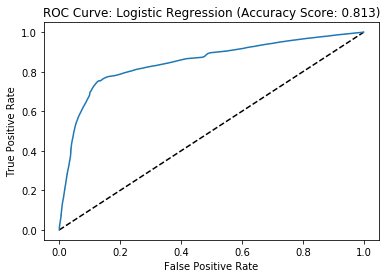

In [39]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = pipeline.predict_proba(X_feb)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_feb, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: Logistic Regression (Accuracy Score: {round(pipeline.score(X_feb, y_feb),3)})')
plt.show()

In [40]:
pipeline.score(X_feb, y_feb)

0.8133021039454024

#### Random Forest

In [41]:
# Build Model
clf = RandomForestClassifier(random_state=42)
steps = [('scaler', StandardScaler()),
         ('RandomForest', clf)]
pipeline = Pipeline(steps)

#parameters = {'Classifier__n_estimators': [500,1000,100]}
pipeline.fit(X_feb, y_feb)

cross_val_scores= cross_val_score(pipeline, X_feb, y_feb, cv=5, scoring='neg_log_loss')
scores["Random Forest"] = np.mean(cross_val_scores) * -1

print("Random Forest Cross-Validation Scores:")
for score in (cross_val_scores * -1):
    print(f'{round(score,2)}')
print(f'Average Score on 5-Folds: {round(scores["Random Forest"],2)}')

Random Forest Cross-Validation Scores:
1.4
1.48
1.39
1.46
1.45
Average Score on 5-Folds: 1.44


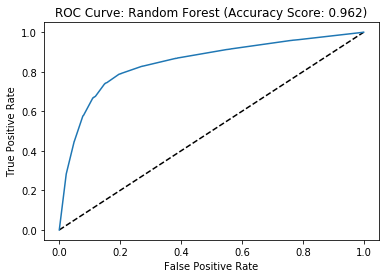

In [467]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = pipeline.predict_proba(X_feb)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_feb, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: Random Forest (Accuracy Score: {round(pipeline.score(X_feb, y_feb), 3)})')
plt.show()

#### Adaptive Boosting Classifier

In [479]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(random_state=42)
steps = [('scaler', StandardScaler()),
         ('AdaBoost', clf)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb, y_feb)

cross_val_scores= cross_val_score(pipeline, X_feb, y_feb, cv=5, scoring='neg_log_loss')
scores["AdaBoost"] = np.mean(cross_val_scores) * -1

print("AdaBoost Cross-Validation Scores:")
for score in (cross_val_scores * -1):
    print(f'{round(score,2)}')
print(f'Average Score on 5-Folds: {round(scores["AdaBoost"],2)}')

AdaBoost Cross-Validation Scores:
0.68
0.68
0.68
0.68
0.68
Average Score on 5-Folds: 0.68


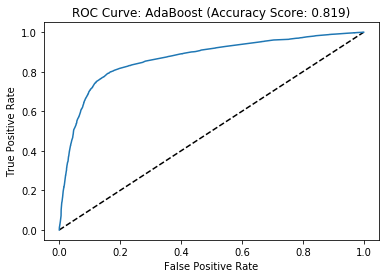

In [469]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = pipeline.predict_proba(X_feb)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_feb, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: AdaBoost (Accuracy Score: {round(pipeline.score(X_feb, y_feb), 3)})')
plt.show()

#### Gradient Boosting Classifier

In [480]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=42)
steps = [('scaler', StandardScaler()),
         ('GradientBoost', clf)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb, y_feb)

cross_val_scores= cross_val_score(pipeline, X_feb, y_feb, cv=5, scoring='neg_log_loss')
scores["GradientBoost"] = np.mean(cross_val_scores) * -1

print("GradientBoost Cross-Validation Scores:")
for score in (cross_val_scores * -1):
    print(f'{round(score,2)}')
print(f'Average Score on 5-Folds: {round(scores["GradientBoost"],2)}')

GradientBoost Cross-Validation Scores:
0.42
0.43
0.43
0.42
0.43
Average Score on 5-Folds: 0.43


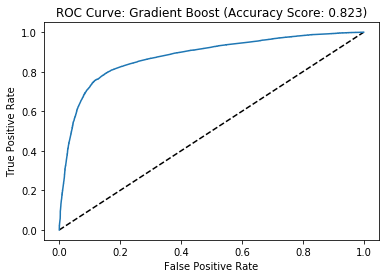

In [471]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = pipeline.predict_proba(X_feb)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_feb, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: Gradient Boost (Accuracy Score: {round(pipeline.score(X_train, y_train), 3)})')
plt.show()

#### Extreme Gradient Boosting

In [481]:
clf = XGBClassifier(random_state=42)
steps = [('scaler', StandardScaler()),
         ('XGradientBoost', clf)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb, y_feb)

cross_val_scores= cross_val_score(pipeline, X_feb, y_feb, cv=5, scoring='neg_log_loss')
scores["XGradientBoost"] = np.mean(cross_val_scores) * -1

print("XGradientBoost Cross-Validation Scores:")
for score in (cross_val_scores * -1):
    print(f'{round(score,2)}')
print(f'Average Score on 5-Folds: {round(scores["XGradientBoost"],2)}')

XGradientBoost Cross-Validation Scores:
0.42
0.43
0.43
0.42
0.43
Average Score on 5-Folds: 0.43


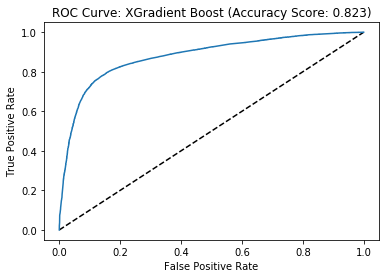

In [475]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = pipeline.predict_proba(X_feb)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_feb, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: XGradient Boost (Accuracy Score: {round(pipeline.score(X_feb, y_feb), 3)})')
plt.show()

In [488]:
scores = sorted(scores.items(), key=lambda score: score[1])

for i in range(len(scores)):
    print((scores[i][0], scores[i][1]))

('XGradientBoost', 0.4278696677673399)
('GradientBoost', 0.428462087175941)
('Logistic Regression', 0.4629922200086612)
('AdaBoost', 0.6816917932601727)
('Random Forest', 1.4643558751548718)


XGradientBoost seems to be the most effective model with the lowest log loss score of 0.427. We will hypertune the parameters of this classifer and perform principal component analysis to better the model.

### Fine Tuning Hyperparameters

We will be adjusting the following parameters:
* max_depth
* learning_rate
* colsample_bytree

In [495]:
model = XGBClassifier()
steps = [('scaler', StandardScaler()),
         ('XGB', model)]
pipeline = Pipeline(steps)

parameters = {'XGB__max_depth': range(6,11),
             'XGB__learning_rate': np.arange(0.01,0.11,.01),
             'XGB__colsample_bytree': np.arange(0.3, 0.9, 0.1)}

cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'XGB__max_depth': range(6, 11), 'XGB__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]), 'XGB__colsample_bytree': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [496]:
cv.best_params_

{'XGB__colsample_bytree': 0.8000000000000003,
 'XGB__learning_rate': 0.05,
 'XGB__max_depth': 8}

In [497]:
cv.score(X_train, y_train, sco)

0.8392965311149699

In [512]:
cross_val_score(final_model, X_train, y_train, cv=5, scoring='neg_log_loss')

array([-0.41379306, -0.42190345, -0.41630123, -0.41446563, -0.42198864])

In [522]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = cv.predict_proba(X_feb)[:,1]
log_loss(y_feb, y_pred_prob)

0.39406185962392304

According to the GridSearch cross validation, the best parameters are colsample_bytree: 0.8, learning_rate: 0.05, and max_depth: 8. This model results in 83.9% accuracy and a log loss of 0.388, which is a slight improvement from the default model.

In [47]:
final_model = XGBClassifier(max_depth = 8, learning_rate = 0.05, colsample_bytree = 0.8)

## Feature Selection

We can further improve the model by taking feature importance into account. Below, we use Mutual Information (MI) as a scoring method to rank each feature. Mutual information between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [509]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

kbest = SelectKBest(score_func=mutual_info_classif, k=5)
kbest.fit(X_feb, y_feb)

feature_names = X_feb.columns
feature_scores = list(zip(feature_names, kbest.scores_))

feature_scores.sort(key=lambda x:x[1], reverse=True)

for item in feature_scores[:10]:
    print(f"Score of \"{item[0]}\": {round(item[1], 2)}")

Score of "avg_is_auto_renew": 0.19
Score of "trans_count": 0.15
Score of "avg_actual_amount_paid": 0.13
Score of "avg_is_cancel": 0.08
Score of "avg_payment_plan_7": 0.07
Score of "avg_discount_received": 0.06
Score of "registered_via_7": 0.06
Score of "avg_payment_plan_30": 0.03
Score of "age": 0.02
Score of "registered_via_4": 0.02


In [588]:
kbestscores = []

sc = StandardScaler()
X_feb_norm = sc.fit_transform(X_feb)

for rank in [30, 32, 35, 40, 42, 48]:
    kbest = SelectKBest(score_func=mutual_info_classif, \
                        k=rank)
    kbest.fit(X_feb_norm, y_feb)
    X_new = kbest.transform(X_feb_norm)

    X_train, X_test, y_train, y_test = train_test_split(X_new, y_feb, test_size=0.2, random_state=42)

    final_model.fit(X_train, y_train)

    y_pred_prob = final_model.predict_proba(X_train)[:,1]
    gbr_score = log_loss(y_train, y_pred_prob)
    kbestscores.append((rank, gbr_score))

for item in kbestscores:
    print(f"Score with Only the Top {item[0]} Features: {round(item[1],4)}")

Score with Only the Top 30 Features: 0.3919
Score with Only the Top 32 Features: 0.3901
Score with Only the Top 35 Features: 0.3896
Score with Only the Top 40 Features: 0.3907
Score with Only the Top 42 Features: 0.3899
Score with Only the Top 48 Features: 0.3887


## PCA (Dimension Reduction)

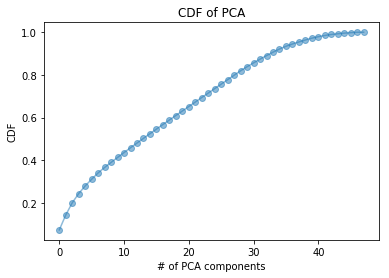

In [586]:
# Normalize feature set
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_feb)
X_test = sc.transform(X_march)

# Applying PCA
from sklearn.decomposition import PCA

pca = PCA()  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)  

# PCA CDF
explained_variance = pca.explained_variance_ratio_     
pca_df = pd.DataFrame(list(zip(range(1,49), np.cumsum(explained_variance))), columns = ['number', 'explained_variance'])

# Plot CDF
plt.plot(np.cumsum(explained_variance), marker='o', alpha = 0.5)
plt.title('CDF of PCA')
plt.xlabel('# of PCA components')
plt.ylabel('CDF')
plt.show()

In [575]:
# PCA explain 80 - 95% variance
pca_df[(pca_df.explained_variance > .8) & (pca_df.explained_variance < .95)]

,number,explained_variance
28,29,0.819446
29,30,0.838448
30,31,0.856410
31,32,0.874048
32,33,0.890449
33,34,0.906596
34,35,0.921476
35,36,0.934251
36,37,0.945005


In [582]:
pcabest = []
for i in range(29, 38):
    pca = PCA(n_components=i)  
    X_new = pca.fit_transform(X_train)  
    final_model.fit(X_new, y_feb)
    y_pred_prob = final_model.predict_proba(X_new)[:,1]
    gbr_score = log_loss(y_feb, y_pred_prob)
    pcabest.append((i, gbr_score))    
    
for item in pcabest:
    print(f"Score with Only {item[0]} PCA components: {round(item[1],4)}")

Score with Only the Top 29 Features: 0.4062
Score with Only the Top 30 Features: 0.4067
Score with Only the Top 31 Features: 0.405
Score with Only the Top 32 Features: 0.4055
Score with Only the Top 33 Features: 0.4038
Score with Only the Top 34 Features: 0.4023
Score with Only the Top 35 Features: 0.3998
Score with Only the Top 36 Features: 0.3974
Score with Only the Top 37 Features: 0.3958


## Fitting the Final Model

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_feb_norm = sc.fit_transform(X_feb)
# Fit the final model on train data
kbest = SelectKBest(score_func=mutual_info_classif, k = 35)
kbest.fit(X_feb_norm, y_feb)
X_new = kbest.transform(X_feb_norm)

final_model.fit(X_new, y_feb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [53]:
# Scores for Train data
y_pred_prob = final_model.predict_proba(X_new)[:,1]

print(f'Accuracy score: {final_model.score(X_new, y_feb)}')
print(f'Log Loss: {log_loss(y_feb, y_pred_prob)}')

Accuracy score: 0.8369906715664499
Log Loss: 0.39342863247443444


In [50]:
# Using final model on test data
sc = StandardScaler()
X_mar_norm = sc.fit_transform(X_march)
X_test = kbest.transform(X_mar_norm)

y_pred_prob = final_model.predict_proba(X_test)[:,1]

print(f'Accuracy score: {final_model.score(X_test, y_march)}')
print(f'Log Loss: {log_loss(y_march, y_pred_prob)}')

Accuracy score: 0.7885331300825811
Log Loss: 0.46549521458662974
